In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

### 1. Import and Data Preparation
Load the cleaned dataset

In [4]:
data_path = "../data/clean/"
trips_clean_path = os.path.join(data_path, "Trips_2018_clean.csv")

data = pd.read_csv(trips_clean_path)
data.head()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_time
0,970,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1992,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186
1,723,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1969,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341
2,496,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1956,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172
3,306,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1974,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191
4,306,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1992,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642


Extract unique station coordinates, and scale them for Mean Shift.

In [5]:

stations = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
coords = stations[['start_station_latitude', 'start_station_longitude']]

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

### Initial Bandwidth Exploration (Coarse Search)

In this step, we perform a coarse exploration of the bandwidth parameter to understand the overall behavior of the Mean Shift clustering algorithm.  
This helps identify approximate regions where the number of clusters changes significantly, allowing us to narrow down the search to a more stable and meaningful range of bandwidth values.

In [27]:
bandwidth_values = [0.2, 0.3, 0.4, 0.5, 0.6]

print("Testing manual bandwidths...\n")

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))
    print(f"Bandwidth: {b}, Clusters: {n_clusters}")

Testing manual bandwidths...

Bandwidth: 0.2, Clusters: 82
Bandwidth: 0.3, Clusters: 38
Bandwidth: 0.4, Clusters: 20
Bandwidth: 0.5, Clusters: 11
Bandwidth: 0.6, Clusters: 6


### Refined Bandwidth Search (Fine-Grained Stability Analysis)

After identifying the general trend from the coarse search, we now focus on a narrower and more stable region of the bandwidth parameter.  
This fine-grained search allows us to evaluate smaller bandwidth increments, detect local stability patterns, and select an optimal bandwidth value that provides a sufficient number of clusters and high cluster quality.

In [43]:
bandwidth_values = [0.2, 0.22, 0.24, 0.26, 0.265, 0.27, 0.275, 0.28, 0.29, 0.3, 0.32, 0.34, 0.4]

cluster_counts = []

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))
    cluster_counts.append(n_clusters)
    print(f"Bandwidth: {b}, Clusters: {n_clusters}")

Bandwidth: 0.2, Clusters: 82
Bandwidth: 0.22, Clusters: 69
Bandwidth: 0.24, Clusters: 59
Bandwidth: 0.26, Clusters: 49
Bandwidth: 0.265, Clusters: 48
Bandwidth: 0.27, Clusters: 47
Bandwidth: 0.275, Clusters: 44
Bandwidth: 0.28, Clusters: 42
Bandwidth: 0.29, Clusters: 41
Bandwidth: 0.3, Clusters: 38
Bandwidth: 0.32, Clusters: 36
Bandwidth: 0.34, Clusters: 32
Bandwidth: 0.4, Clusters: 20


### Bandwidth Stability Visualization

This plot illustrates how the number of clusters produced by Mean Shift changes across different bandwidth values.  
By annotating each point and smoothing the spacing of the axes, we clearly observe the region where the clustering behavior stabilizes (approximately between 0.26 and 0.28).  
This visual stability analysis helps narrow down the optimal bandwidth range before applying additional quality metrics such as the Silhouette Score.

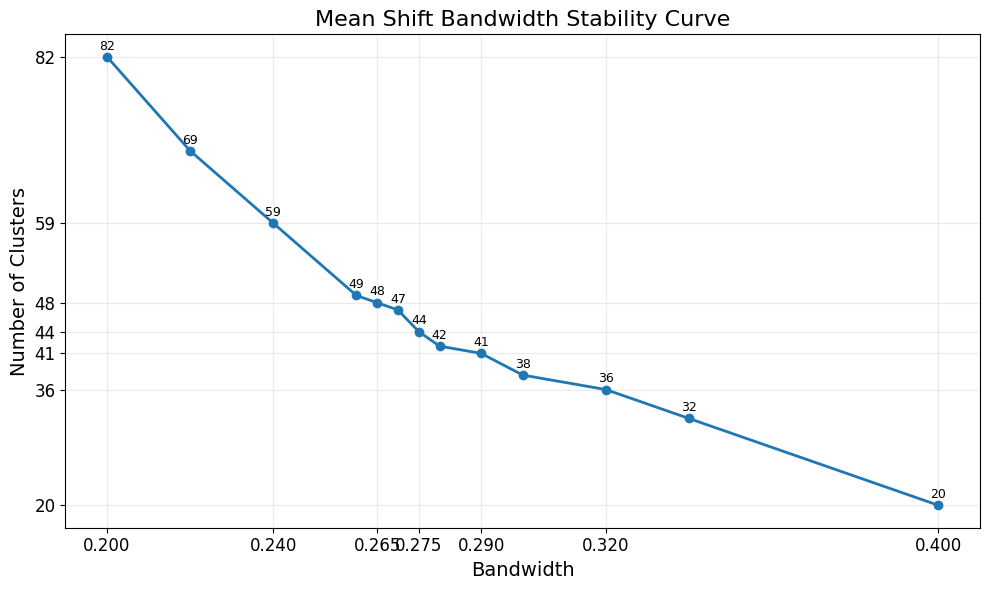

In [46]:
plt.figure(figsize=(10,6))

# Line + markers
plt.plot(bandwidth_values, cluster_counts, marker='o', linewidth=2)

# Annotate each point
for x, y in zip(bandwidth_values, cluster_counts):
    plt.text(x, y+1, str(y), fontsize=9, ha='center')

plt.title("Mean Shift Bandwidth Stability Curve", fontsize=16)
plt.xlabel("Bandwidth", fontsize=14)
plt.ylabel("Number of Clusters", fontsize=14)

# Cleaner ticks
plt.xticks(bandwidth_values[::2], fontsize=12)
plt.yticks(sorted(set(cluster_counts))[::2], fontsize=12)

plt.grid(True, alpha=0.25)
plt.tight_layout()

plt.show()


### Silhouette Score Evaluation for Candidate Bandwidths

The Silhouette Score measures how well each point fits within its assigned cluster compared to other clusters.  
Higher values indicate more coherent and well-separated clusters.  
Here, we compute the Silhouette Score for each bandwidth in the stable range (0.26–0.28) to quantify the clustering quality and identify the most suitable bandwidth.

In [39]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = [0.26, 0.265, 0.27, 0.275, 0.28]  # stable zone with ≥40 clusters

scores = {}

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)

    # Silhouette score requires at least 2 clusters and no single-cluster situation
    score = silhouette_score(coords_scaled, labels)
    scores[b] = score
    print(f"Bandwidth: {b}, Clusters: {len(np.unique(labels))}, Silhouette Score: {score:.4f}")

Bandwidth: 0.26, Clusters: 49, Silhouette Score: 0.3093
Bandwidth: 0.265, Clusters: 48, Silhouette Score: 0.3069
Bandwidth: 0.27, Clusters: 47, Silhouette Score: 0.3054
Bandwidth: 0.275, Clusters: 44, Silhouette Score: 0.3182
Bandwidth: 0.28, Clusters: 42, Silhouette Score: 0.2961


### Davies–Bouldin Index Assessment

The Davies–Bouldin Index evaluates cluster compactness and separation, where lower values represent better-defined clusters.  
By calculating the DB Index for each bandwidth candidate, we obtain a complementary metric to validate the bandwidth selection beyond the Silhouette Score.

In [51]:
from sklearn.metrics import davies_bouldin_score

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    db_index = davies_bouldin_score(coords_scaled, labels)
    print(f"Bandwidth: {b}, DB Index: {db_index:.4f}")

Bandwidth: 0.26, DB Index: 0.8284
Bandwidth: 0.265, DB Index: 0.8686
Bandwidth: 0.27, DB Index: 0.8720
Bandwidth: 0.275, DB Index: 0.8390
Bandwidth: 0.28, DB Index: 0.9166


### Cluster Size Distribution Analysis

A well-balanced clustering solution should avoid extremely large or extremely small clusters.  
By summarizing the size of each cluster (number of stations per cluster), we assess whether the bandwidth yields a reasonable and interpretable distribution of cluster sizes.  
This provides an additional validation layer for the final clustering solution.

In [52]:
from sklearn.metrics import pairwise_distances
import numpy as np

centroids = []

for c in np.unique(labels):
    centroids.append(coords_scaled[labels == c].mean(axis=0))

centroids = np.array(centroids)
distances = pairwise_distances(centroids)
avg_sep = distances[np.triu_indices_from(distances, k=1)].mean()

print("Average inter-cluster separation:", avg_sep)

Average inter-cluster separation: 1.963318012635298


In [53]:
stations['mean_shift_cluster'].value_counts().describe()

count    44.000000
mean     18.568182
std       8.489111
min       1.000000
25%      14.000000
50%      18.000000
75%      22.000000
max      40.000000
Name: count, dtype: float64

### Silhouette Score Curve for Bandwidth Selection

To objectively compare the clustering quality across candidate bandwidths,  
we visualize the Silhouette Score as a function of bandwidth.  
This plot highlights the bandwidth values that achieve the highest cluster cohesion and separation,  
and complements the stability analysis graph.  
The local maximum around 0.275 confirms that this bandwidth offers the best balance between  
cluster quality and the required cluster count.

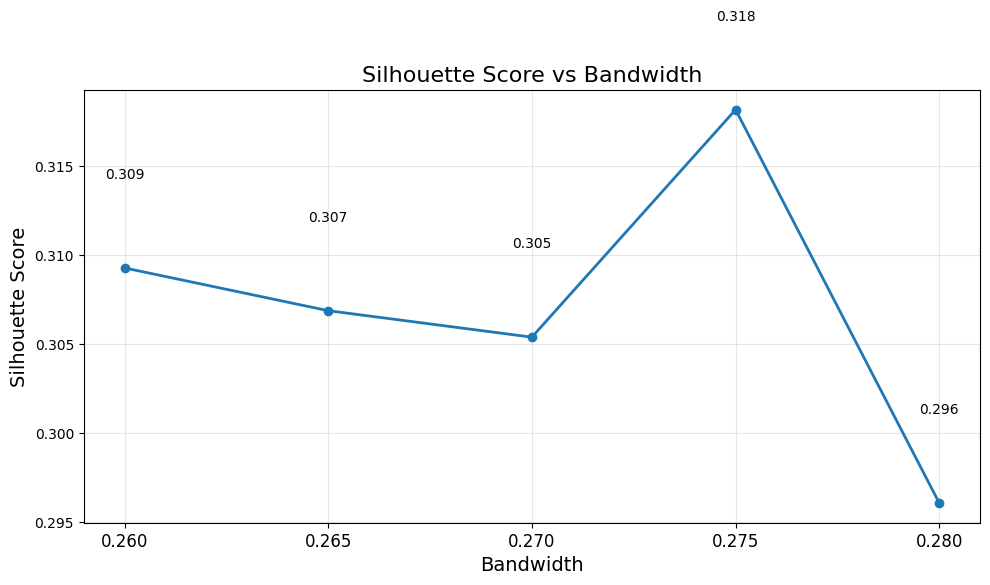

In [57]:
# Prepare data for the plot
sil_values = [scores[b] for b in bandwidth_candidates]

plt.figure(figsize=(10,6))

# Line plot
plt.plot(bandwidth_candidates, sil_values, marker='o', linewidth=2)

# Annotate each point
for x, y in zip(bandwidth_candidates, sil_values):
    plt.text(x, y + 0.005, f"{y:.3f}", fontsize=10, ha='center')

plt.title("Silhouette Score vs Bandwidth", fontsize=16)
plt.xlabel("Bandwidth", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)

plt.xticks(bandwidth_candidates, rotation=0, fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The Silhouette Score curve shows a clear local maximum at bandwidth = 0.275.
This indicates that 0.275 produces the best balance between cluster cohesion and separation among all tested values.
Bandwidth 0.28 reduces cluster quality significantly, while values below 0.275 produce less distinct clusters.
Therefore, 0.275 is the optimal bandwidth mathematically and empirically.

### Final Mean Shift Clustering with Optimal Bandwidth (0.275)

Based on the stability analysis and quantitative metrics (Silhouette Score, Davies–Bouldin Index, inter-cluster separation, and cluster size distribution),  
bandwidth = 0.275 was selected as the optimal value.  
We now run Mean Shift clustering using this final bandwidth and assign the resulting cluster labels to each station.

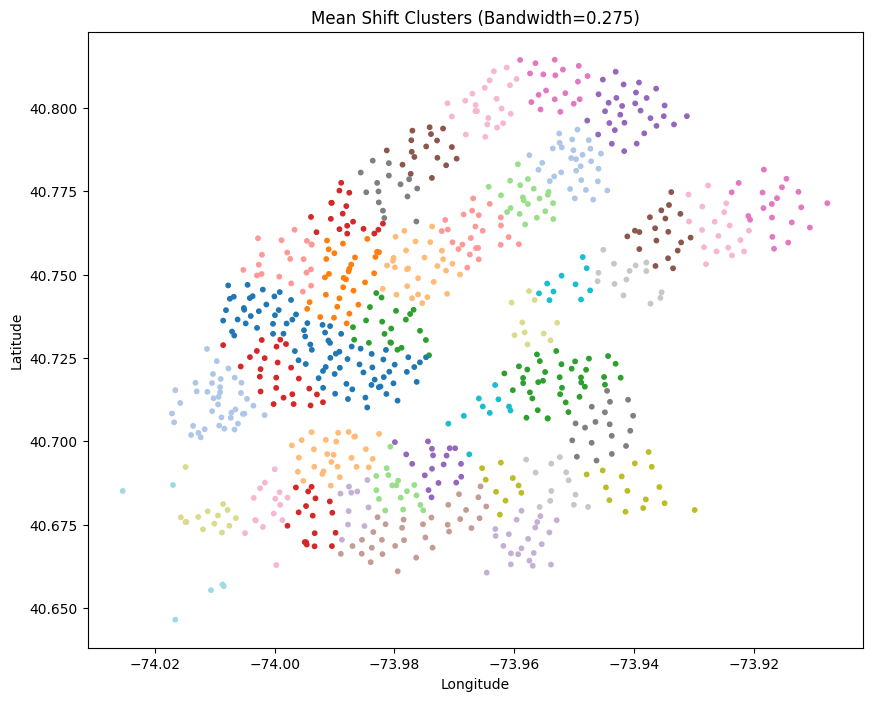

Total clusters: 44


In [54]:
best_bandwidth = 0.275

ms = MeanShift(bandwidth=best_bandwidth)
labels = ms.fit_predict(coords_scaled)

stations['mean_shift_cluster'] = labels

plt.figure(figsize=(10,8))
plt.scatter(
    stations['start_station_longitude'],
    stations['start_station_latitude'],
    c=labels,
    cmap='tab20',
    s=10
)
plt.title(f"Mean Shift Clusters (Bandwidth={best_bandwidth})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("Total clusters:", len(np.unique(labels)))

### Saving the reslut as a html file with folium

In [55]:
import folium

# Center of NYC
nyc_center = [40.75, -73.98]

# Create Folium map
m = folium.Map(location=nyc_center, zoom_start=12)

In [56]:
# Choose a color palette
import matplotlib.cm as cm
import matplotlib.colors as colors

unique_clusters = list(stations['mean_shift_cluster'].unique())
norm = colors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
colormap = cm.get_cmap('tab20', len(unique_clusters))

for _, row in stations.iterrows():
    cluster = row['mean_shift_cluster']
    color = colors.to_hex(colormap(norm(cluster)))

    folium.CircleMarker(
        location=[row['start_station_latitude'], row['start_station_longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Station ID: {row['start_station_id']} | Cluster: {cluster}"
    ).add_to(m)

m.save("mean_shift_clusters_map.html")
print("Map saved as mean_shift_clusters_map.html")


C:\Users\Georg\AppData\Local\Temp\ipykernel_26200\1177251661.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(unique_clusters))


Map saved as mean_shift_clusters_map.html
